<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import glob

import argparse
from pathlib import Path
import os

from veloce_luminosa_reduction import config

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from astropy.io import fits

# from veloce_luminosa_reduction.plotting import plot_ccd_imshow, create_rainbow_colormap, create_transparent_greyscale_colormap
# from veloce_luminosa_reduction.utils import identify_calibration_and_science_runs, match_month_to_date, read_veloce_fits_image_and_metadata, polynomial_function, radial_velocity_shift, interpolate_spectrum
from veloce_luminosa_reduction.utils import polynomial_function
# from veloce_luminosa_reduction.reduction import substract_overscan, extract_initial_order_ranges_and_coeffs
from veloce_luminosa_reduction.calibration import get_wavelength_coeffs_from_vdarc
# from veloce_luminosa_reduction.korg_synthesis import calculate_synthetic_korg_spectrum
# from veloce_luminosa_reduction.post_processing import degrade_resolution_with_uncertainty, interpolate_orders_and_merge, coadd_spectra

# import time
import numpy as np
# from numpy.polynomial.chebyshev import Chebyshev
from scipy.signal import medfilt, find_peaks
# from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
# from astropy.table import Table
# from astropy.time import Time
# from astropy.coordinates import SkyCoord, EarthLocation
# import astropy.units as u
# SSO = EarthLocation.of_site('Siding Spring Observatory')

In [2]:
initial_wavelength_coeffs = get_wavelength_coeffs_from_vdarc()

In [3]:
config.date = '240219'

In [4]:
path = config.working_directory+'reduced_data/'+config.date+'/minimal_spectra/'
print(path, len(path))
science_objects = [x[79:] for x in glob.glob(path+'*')]
science_objects.sort()
science_objects

/Users/buder/git/veloce_luminosa_reduction/reduced_data/240219/minimal_spectra/ 79


['HIP37664',
 'HIP47431',
 'HIP50887',
 'HIP56127',
 'HIP57757',
 'HIP63608',
 'HIP65721',
 'HIP67459',
 'HIP69673',
 'HIP71681',
 'HIP71683',
 'HIP73184',
 'HIP74975']

In [5]:
def fourth_order(xdata, *coeffs):
    c0, c1, c2, c3, c4 = coeffs
    return(c0 + c1 * (xdata-2064) + c2 * (xdata-2064)**2 + c3 * (xdata-2064)**3 + c4 * (xdata-2064)**4)

In [ ]:
# Calibrate wavelength

for science_object in science_objects:
    
    with PdfPages(path+science_object+'/minimal_'+science_object+'.pdf') as pdf:

        with fits.open(path+science_object+'/minimal_'+science_object+'.fits', mode='update') as file:

            for order in range(1,len(file)):
                
                print(file[order].header['EXTNAME'])

                if file[order].header['EXTNAME'] in [
                    science_object+'_CCD_1_ORDER_139',
                    science_object+'_CCD_1_ORDER_140',
                    science_object+'_CCD_1_ORDER_141', # Hgamma
                    science_object+'_CCD_1_ORDER_142',
                    science_object+'_CCD_1_ORDER_143',
                    science_object+'_CCD_1_ORDER_144',
                    science_object+'_CCD_1_ORDER_145',
                    science_object+'_CCD_1_ORDER_146',
                    science_object+'_CCD_1_ORDER_147',
                    science_object+'_CCD_1_ORDER_148',
                    science_object+'_CCD_1_ORDER_149',
                    science_object+'_CCD_1_ORDER_150',
                    science_object+'_CCD_1_ORDER_151',
                    science_object+'_CCD_1_ORDER_155', # CaHK Doublet
                    science_object+'_CCD_2_ORDER_103', # Na Doublet
                    science_object+'_CCD_2_ORDER_104', # Na Doublet
                    science_object+'_CCD_2_ORDER_105', # Na Doublet
                    science_object+'_CCD_2_ORDER_106',
                    science_object+'_CCD_2_ORDER_107',
                    science_object+'_CCD_2_ORDER_108',
                    science_object+'_CCD_2_ORDER_109',
                    science_object+'_CCD_2_ORDER_117', # MgI Triplet
                    science_object+'_CCD_2_ORDER_118', # MgI Triplet
                    science_object+'_CCD_2_ORDER_119', # MgI Triplet
                    science_object+'_CCD_2_ORDER_124',
                    science_object+'_CCD_2_ORDER_125',
                    science_object+'_CCD_2_ORDER_126', # Hbeta
                    science_object+'_CCD_2_ORDER_127',
                    science_object+'_CCD_2_ORDER_128',
                    science_object+'_CCD_2_ORDER_129',
                    science_object+'_CCD_2_ORDER_130',
                    science_object+'_CCD_3_ORDER_70',
                    science_object+'_CCD_3_ORDER_71', # CaII Triplet
                    science_object+'_CCD_3_ORDER_72',
                    science_object+'_CCD_3_ORDER_73',
                    science_object+'_CCD_3_ORDER_74',
                    science_object+'_CCD_3_ORDER_75',
                    science_object+'_CCD_3_ORDER_76',
                    science_object+'_CCD_3_ORDER_78',
                    science_object+'_CCD_3_ORDER_79', # OI Triplet
                    science_object+'_CCD_3_ORDER_80',
                    science_object+'_CCD_3_ORDER_81',
                    science_object+'_CCD_3_ORDER_91',
                    science_object+'_CCD_3_ORDER_92',
                    science_object+'_CCD_3_ORDER_93', # Halpha
                    science_object+'_CCD_3_ORDER_94',
                    science_object+'_CCD_3_ORDER_95',
                    science_object+'_CCD_3_ORDER_103', #Na Doublet
                    science_object+'_CCD_3_ORDER_104'
                ]:

                    wavelength_coefficients = np.array(np.loadtxt('../veloce_luminosa_reduction/fixed_arc_positions/'+file[order].header['EXTNAME'].lower()[len(science_object)+1:]+'_px_wl.txt'))

                    fourth_order_coeffs, x = curve_fit(fourth_order,
                        wavelength_coefficients[:,0],
                        wavelength_coefficients[:,1],
                        p0 = [np.median(wavelength_coefficients[:,1]), 0.05, 0.0, 0.0, 0.0]
                    )
                    wavelength_from_pixels = fourth_order(np.arange(len(file[order].data['WAVE_VAC'])),*fourth_order_coeffs)
                    file[order].data['WAVE_VAC'] = wavelength_from_pixels*10.

                    # Using conversion from Birch, K. P., & Downs, M. J. 1994, Metro, 31, 315
                    # Consistent to the 2024 version of Korg -- which is intended to be used later on.
                    file[order].data['WAVE_AIR'] = file[order].data['WAVE_VAC'] / (1 + 0.0000834254 + 0.02406147 / (130 - (1e4/file[order].data['WAVE_VAC'])**2) + 0.00015998 / (38.9 - (1e4/file[order].data['WAVE_VAC'])**2))

                    f, gs = plt.subplots(4,1,figsize=(15,10),sharex=True)
                    f.suptitle(science_object+' '+file[order].header['EXTNAME'])

                    ax = gs[0]
                    ax.plot(file[order].data['SCIENCE']/file[order].data['FLAT'], lw=1)
                    ax.set_yscale('log')
                    ax.set_ylabel('Science')

                    ticks = np.arange(0,4128,100)
                    ax.set_xticks(ticks,labels=ticks,rotation=90)
                    ax.set_xlim(ticks[0],ticks[-1])   
                    ax2 = ax.twiny()
                    ax2.set_xticks(ticks-ticks[0])
                    ax2.set_xticklabels(np.round(file[order].data['WAVE_AIR'][ticks],1),rotation=90)
                    ax2.set_xlabel(r'Air Wavelength $\lambda_\mathrm{air}~/~\mathrm{\AA}$')

                    ax = gs[1]
                    ax.plot(file[order].data['SCIENCE']/file[order].data['SCIENCE_NOISE'], lw=1)
                    ax.set_ylabel('Science Signal-to-Noise')

                    ax = gs[2]
                    ax.plot(file[order].data['THXE']/file[order].data['FLAT'], lw=1)
                    ax.set_yscale('log')
                    ax.set_ylabel('ThXe')

                    ax = gs[3]
                    ax.plot(file[order].data['LC']/file[order].data['FLAT'], lw=0.5)
                    ax.set_yscale('log')
                    ax.set_ylabel('Lc')
                    ax.set_xlabel('Pixel')
                    ax.set_xticks(ticks,labels=ticks,rotation=90)

                    wavelength = file[order].data['WAVE_AIR']
                    science = file[order].data['SCIENCE']/file[order].data['FLAT']
                    thxe = file[order].data['THXE']/file[order].data['FLAT']
                    lc = file[order].data['LC']/file[order].data['FLAT']

                    pdf.savefig()
                    # plt.show()
                    plt.close()

        file.close()

In [ ]:
# Plot ThXe in linear and log as PDF

overwrite = False

file = fits.open(path+science_object+'/minimal_'+science_object+'.fits', mode='update')
    
use_log = False
    
for order in range(1,len(file)):
    
    order_name = file[order].header['EXTNAME'].lower()
    
    thxe = file[order].data['THXE']/file[order].data['FLAT']
    
    thxe_filtered = thxe/medfilt(thxe, kernel_size=51)
    peaks, properties = find_peaks(thxe_filtered, threshold=0.25, distance=12)

    f, ax = plt.subplots(1,1,figsize=(15,2))

    pixels = np.arange(len(thxe_filtered))

    if use_log:
        ax.plot(
            pixels,
            np.log10(thxe_filtered),
            lw = 0.5
        )
        ax.set_ylim(-0.1,np.nanpercentile(np.log10(thxe_filtered),q=98))
    else:
        ax.plot(
            pixels,
            thxe_filtered,
            lw = 0.5
        )
        ax.set_ylim(np.nanpercentile(thxe_filtered,q=0),np.nanpercentile(thxe_filtered,q=99.5))
    ylim = ax.get_ylim()
    for peak in peaks:
        ax.axvline(peak,c='r',lw=0.1,ls='dashed')
        ax.text(peak,0.5*(ylim[0]+ylim[1]),str(peak),rotation=90,ha='right',va='bottom',fontsize=5)

    ax.set_xlim(fourth_order(0, *fourth_order_coeffs),fourth_order(4128, *fourth_order_coeffs))
    ax.set_xlim(0,4128)
    plt.tight_layout()
    
#     if overwrite:
    if order_name[len(science_object)+1:] == 'ccd_1_order_139':
        if use_log:
            plt.savefig('../veloce_luminosa_reduction/fixed_arc_positions/'+order_name[len(science_object)+1:]+'_log.pdf')
        else:
            plt.savefig('../veloce_luminosa_reduction/fixed_arc_positions/'+order_name[len(science_object)+1:]+'.pdf')
    plt.show()
    plt.close()
    
file.close()

In [6]:
wavelength_coefficients = dict()
for order in range(1,len(file)):
    
    order_name = file[order].header['EXTNAME'].lower()
    wavelength_coefficients[order_name] = np.loadtxt('../veloce_luminosa_reduction/fixed_arc_positions/'+order_name+'_px_wl.txt')

NameError: name 'file' is not defined

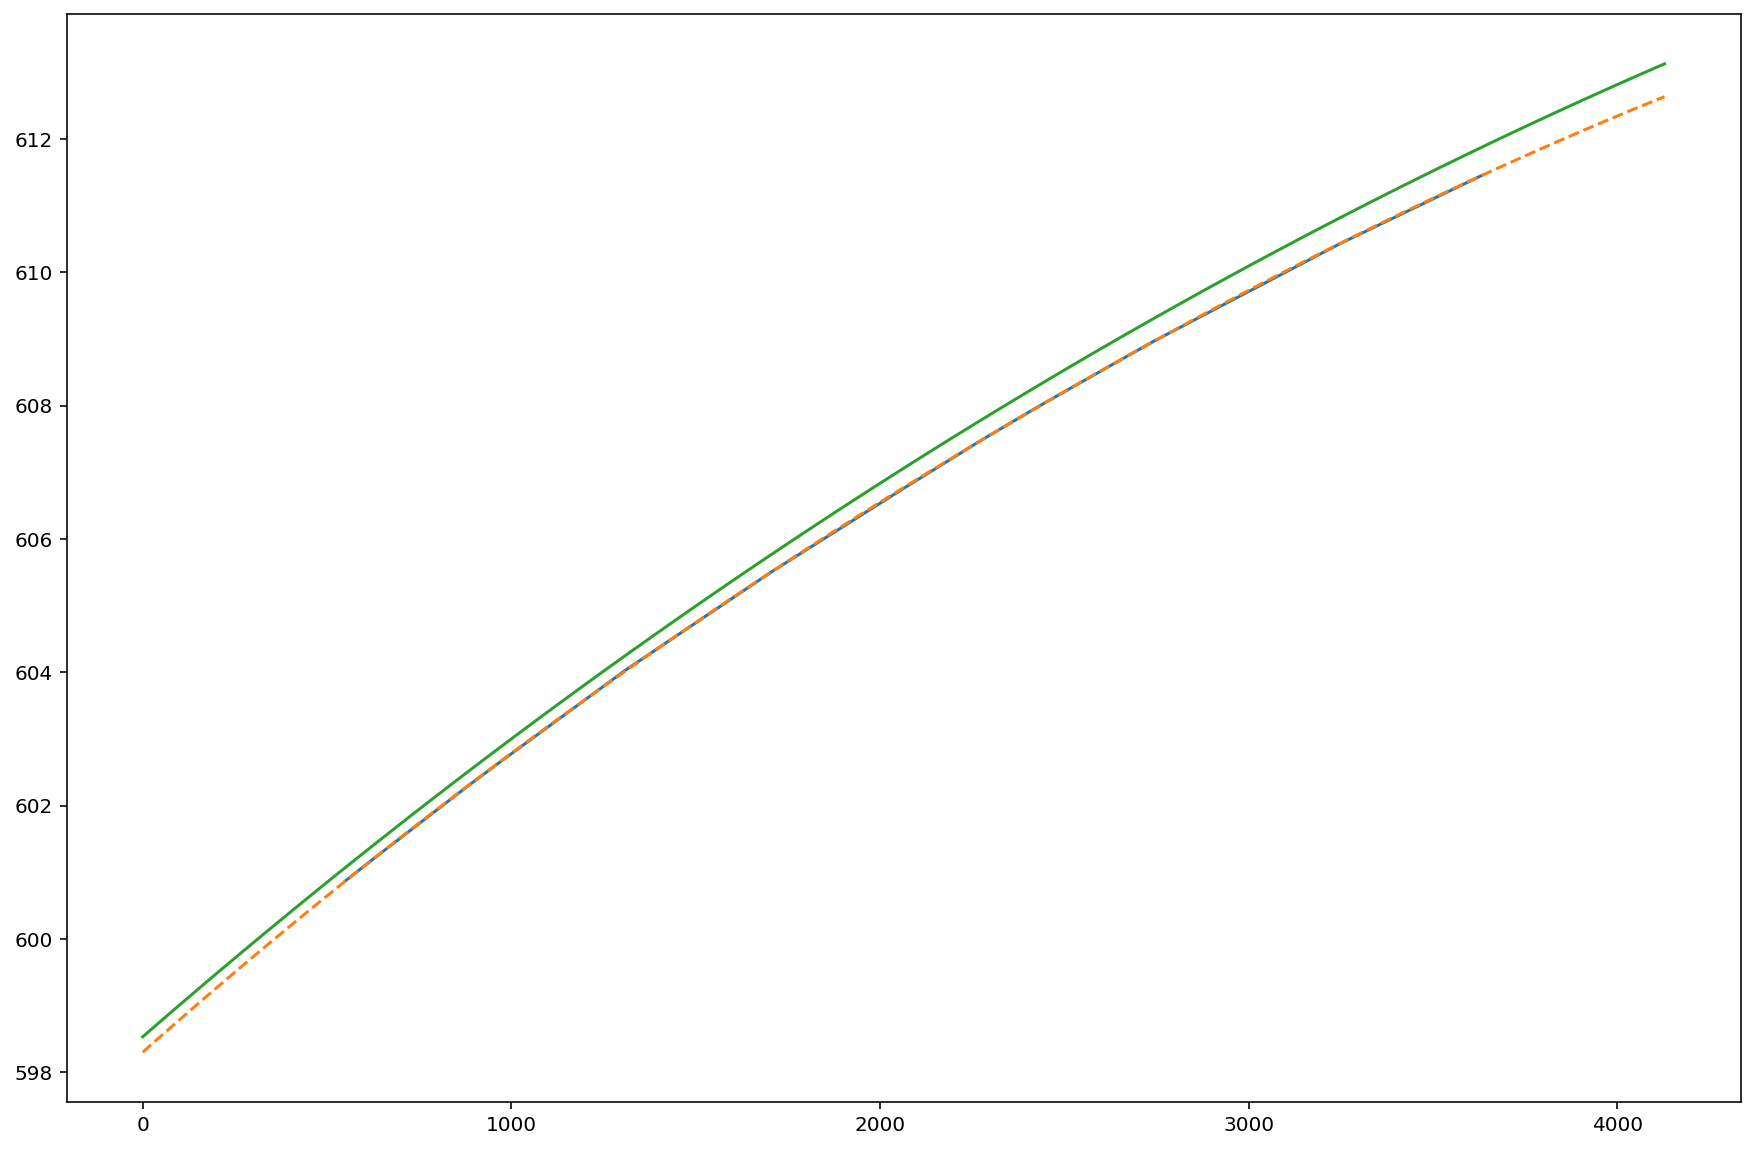

In [195]:
for order_name in ['ccd_3_order_101']:
    
    plt.figure(figsize=(15,10))
    wavelength_coefficients = np.loadtxt('../veloce_luminosa_reduction/fixed_arc_positions/'+order_name+'_px_wl.txt',comments='#')

    def fourth_order(xdata, *coeffs):
        c0, c1, c2, c3, c4 = coeffs
        return(c0 + c1 * (xdata-2064) + c2 * (xdata-2064)**2 + c3 * (xdata-2064)**3 + c4 * (xdata-2064)**4)

    fourth_order_coeffs, x = curve_fit(fourth_order,
              wavelength_coefficients[:,0],
              wavelength_coefficients[:,1],
              p0 = [np.median(wavelength_coefficients[:,1]), 0.05, 0.0, 0.0, 0.0]
    )

    plt.plot(
        wavelength_coefficients[:,0],
        wavelength_coefficients[:,1]
    )
    
    ydata = fourth_order(np.linspace(0,4128,100), *fourth_order_coeffs)
    
    plt.plot(
        np.linspace(0,4128,100),
        ydata,
        ls = 'dashed'
    )

    try:
        adjusted_coeffs = [
            initial_wavelength_coeffs[order_name][0]-1.,
            initial_wavelength_coeffs[order_name][1]+0.0003,
            initial_wavelength_coeffs[order_name][2],
            initial_wavelength_coeffs[order_name][3],
            initial_wavelength_coeffs[order_name][4]
        ]
    except:
        adjusted_coeffs = [
            initial_wavelength_coeffs[order_name][0]-1.5,
            initial_wavelength_coeffs[order_name][1]+0.0003,
            initial_wavelength_coeffs[order_name][2],
            initial_wavelength_coeffs[order_name][3],
            0.0
        ]

    ydata = fourth_order(np.linspace(0,4128,100), *adjusted_coeffs)
        
#     plt.ylim(np.min(ydata),np.max(ydata))

    plt.plot(
        np.linspace(0,4128,100),
        ydata
    )
    plt.show()
    plt.close()

In [8]:
def gaussian(x, b, A, mu, sigma):
    return b + A * np.exp(-(x - mu)**2 / (2 * sigma**2))

In [ ]:
# Gaussian fits to ThXe peaks 

debug = False

overwrite = False

for order in range(1,len(file)):
    file = fits.open(path+science_object+'/minimal_'+science_object+'.fits', mode='update')
    order_name = file[order].header['EXTNAME'].lower()
    thxe = file[order].data['THXE']/file[order].data['FLAT']
    file.close()

    thxe_filtered = thxe/medfilt(thxe, kernel_size=51)
    peaks, properties = find_peaks(thxe_filtered, threshold=1, distance=12)

    peaks_to_save = []

    for peak in peaks:
        
        # create x-data and y-data for fitting
        peak_window = 5
        
        if (peak > peak_window) & (peak < len(thxe) - peak_window):

            pixels_around_peak = np.arange(peak-peak_window, peak+peak_window)
            thxe_around_peak = thxe_filtered[peak-peak_window:peak+peak_window]

            # avoid NaN values
            pixels_around_peak = pixels_around_peak[np.isfinite(thxe_around_peak)]
            thxe_around_peak = thxe_around_peak[np.isfinite(thxe_around_peak)]

            # fit Gaussian
            initial_guess = [0, max(thxe_around_peak), peak, 3]
            try:
                params, cov = curve_fit(gaussian, pixels_around_peak, thxe_around_peak, p0=initial_guess)
                b_fit, A_fit, mu_fit, sigma_fit = params

                if debug:
                    plt.plot(
                        pixels_around_peak,
                        thxe_around_peak,
                        c = 'k'
                    )
                    plt.plot(
                        pixels_around_peak,
                        gaussian(pixels_around_peak, *params),
                        c = 'C0'
                    )

                    plt.axvline(peak, color='C1')
                    plt.axvline(mu_fit, color='C3')
                    plt.show()
                    plt.close()
                    
                try:
                    adjusted_coeffs = [
                        initial_wavelength_coeffs[order_name[len(science_object)+1:]][0]-1.5,
                        initial_wavelength_coeffs[order_name[len(science_object)+1:]][1]+0.0003,
                        initial_wavelength_coeffs[order_name[len(science_object)+1:]][2],
                        initial_wavelength_coeffs[order_name[len(science_object)+1:]][3],
                        initial_wavelength_coeffs[order_name[len(science_object)+1:]][4]
                    ]
                except:
                    adjusted_coeffs = [
                        initial_wavelength_coeffs[order_name[len(science_object)+1:]][0]-1.5,
                        initial_wavelength_coeffs[order_name[len(science_object)+1:]][1]+0.0003,
                        initial_wavelength_coeffs[order_name[len(science_object)+1:]][2],
                        initial_wavelength_coeffs[order_name[len(science_object)+1:]][3],
                        0.0
                    ]

                peaks_to_save.append(['#'+"{:.2f}".format(np.round(mu_fit,2)), str(np.round(polynomial_function(mu_fit-2064,*adjusted_coeffs),2))])

            except:
                pass
            
    if overwrite:
        if order_name[len(science_object)+1:]+'_px_wl' not in ['ccd_1_order_138_px_wl','ccd_1_order_139_px_wl','ccd_1_order_140_px_wl','ccd_1_order_141_px_wl','ccd_1_order_142_px_wl','ccd_1_order_143_px_wl','ccd_1_order_166_px_wl','ccd_1_order_164_px_wl','ccd_1_order_163_px_wl','ccd_3_order_91_px_wl','ccd_3_order_92_px_wl','ccd_3_order_93_px_wl']:
            np.savetxt('../veloce_luminosa_reduction/fixed_arc_positions/'+order_name[len(science_object)+1:]+'_px_wl.txt',np.array(peaks_to_save),fmt='%s')

In [ ]:
lc_filtered = lc/medfilt(lc, kernel_size=51)

peaks, properties = find_peaks(lc_filtered, distance = 7, threshold=0.5, prominence=0.1, width=1)

panels = 8

f, gs = plt.subplots(panels,1,figsize=(15,panels*2))
gs = gs.flatten()

pixels = np.arange(len(lc))
print(len(pixels))

for panel in np.arange(panels):

    ax = gs[panel]
    in_panel = (pixels > panel * 500 - 150) & (pixels < (panel + 1) * 500 + 150)
    peaks_in_panel = (peaks > panel * 500 - 150) & (peaks < (panel + 1) * 500 + 150)
    
    ax.plot(
        pixels[in_panel],
        lc_filtered[in_panel]
    )
    for peak in peaks[peaks_in_panel]:
        ax.axvline(peak,c='r',lw=1)
    


In [ ]:
peaks, properties = find_peaks(lc, distance = 7, threshold=1, prominence=0.2)

panels = 8

f, gs = plt.subplots(panels,1,figsize=(15,panels*2))
gs = gs.flatten()

pixels = np.arange(len(lc))
print(len(pixels))

for panel in np.arange(panels):

    ax = gs[panel]
    in_panel = (pixels > panel * 500 - 150) & (pixels < (panel + 1) * 500 + 150)
    peaks_in_panel = (peaks > panel * 500 - 150) & (peaks < (panel + 1) * 500 + 150)
    
    ax.plot(
        pixels[in_panel],
        lc[in_panel]
    )
    for peak in peaks[peaks_in_panel]:
        ax.axvline(peak,c='r',lw=1)
    


In [ ]:
def lc_wavelength(n, fr = 25.00000000e9, f0 = 9.56000000000e9):
    frequency = fr * n + f0
    return(299792458 / frequency * 10**10)

lc_wavelength(np.arange(17700,18000))

In [ ]:
plt.plot(
    peaks[:-1],
    np.diff(peaks)
)